# Airbnb NYC Price Prediction

### Import Libraries

In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pandas as pd 
import warnings
import seaborn as sns 

In [2]:
warnings.filterwarnings('ignore')

print(tf.__version__)

2.5.0


### Load data

In [8]:
# frac randomly samples a certain amount of data
data = pd.read_csv('./data/airbnb new york.csv').sample(frac=1)
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
16883,13445027,Large sunny Bedroom in Brooklyn Loft,66786569,Raphaëlle,Brooklyn,Williamsburg,40.70475,-73.93663,Private room,62,2,5,2017-12-30,0.13,1,0
25910,20698073,"Hip Modern Brooklyn Studio, Minutes to Manhattan!",148148402,Gary,Brooklyn,Clinton Hill,40.69167,-73.96927,Entire home/apt,129,2,93,2019-07-01,4.15,1,43
38371,30213410,30min➡︎LGA New&Clean Apt with Cozy Terrace Space,204704622,Momoyo,Queens,Elmhurst,40.73885,-73.87553,Private room,33,29,2,2019-06-15,0.71,7,1
42229,32786275,Clean and Simple,82940021,Todd,Manhattan,Hell's Kitchen,40.76341,-73.99306,Entire home/apt,145,3,9,2019-07-01,3.55,1,6
13316,10017050,"Nice and Quiet, lots of trees.",45483124,Maria,Queens,East Elmhurst,40.75836,-73.87631,Private room,700,1,1,2016-01-03,0.02,1,97


In [9]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Data preprocessing

In [10]:
features = data[['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 
                 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
features['reviews_per_month'] = features['reviews_per_month'].fillna(0)

onehot_neighborhood_group = pd.get_dummies(features['neighbourhood_group'])
onehot_room_type = pd.get_dummies(features['room_type'])

features = features.drop(columns=['neighbourhood_group', 'room_type'])
features = pd.concat([features, onehot_neighborhood_group, onehot_room_type], axis=1)

## Data visualization and analysis

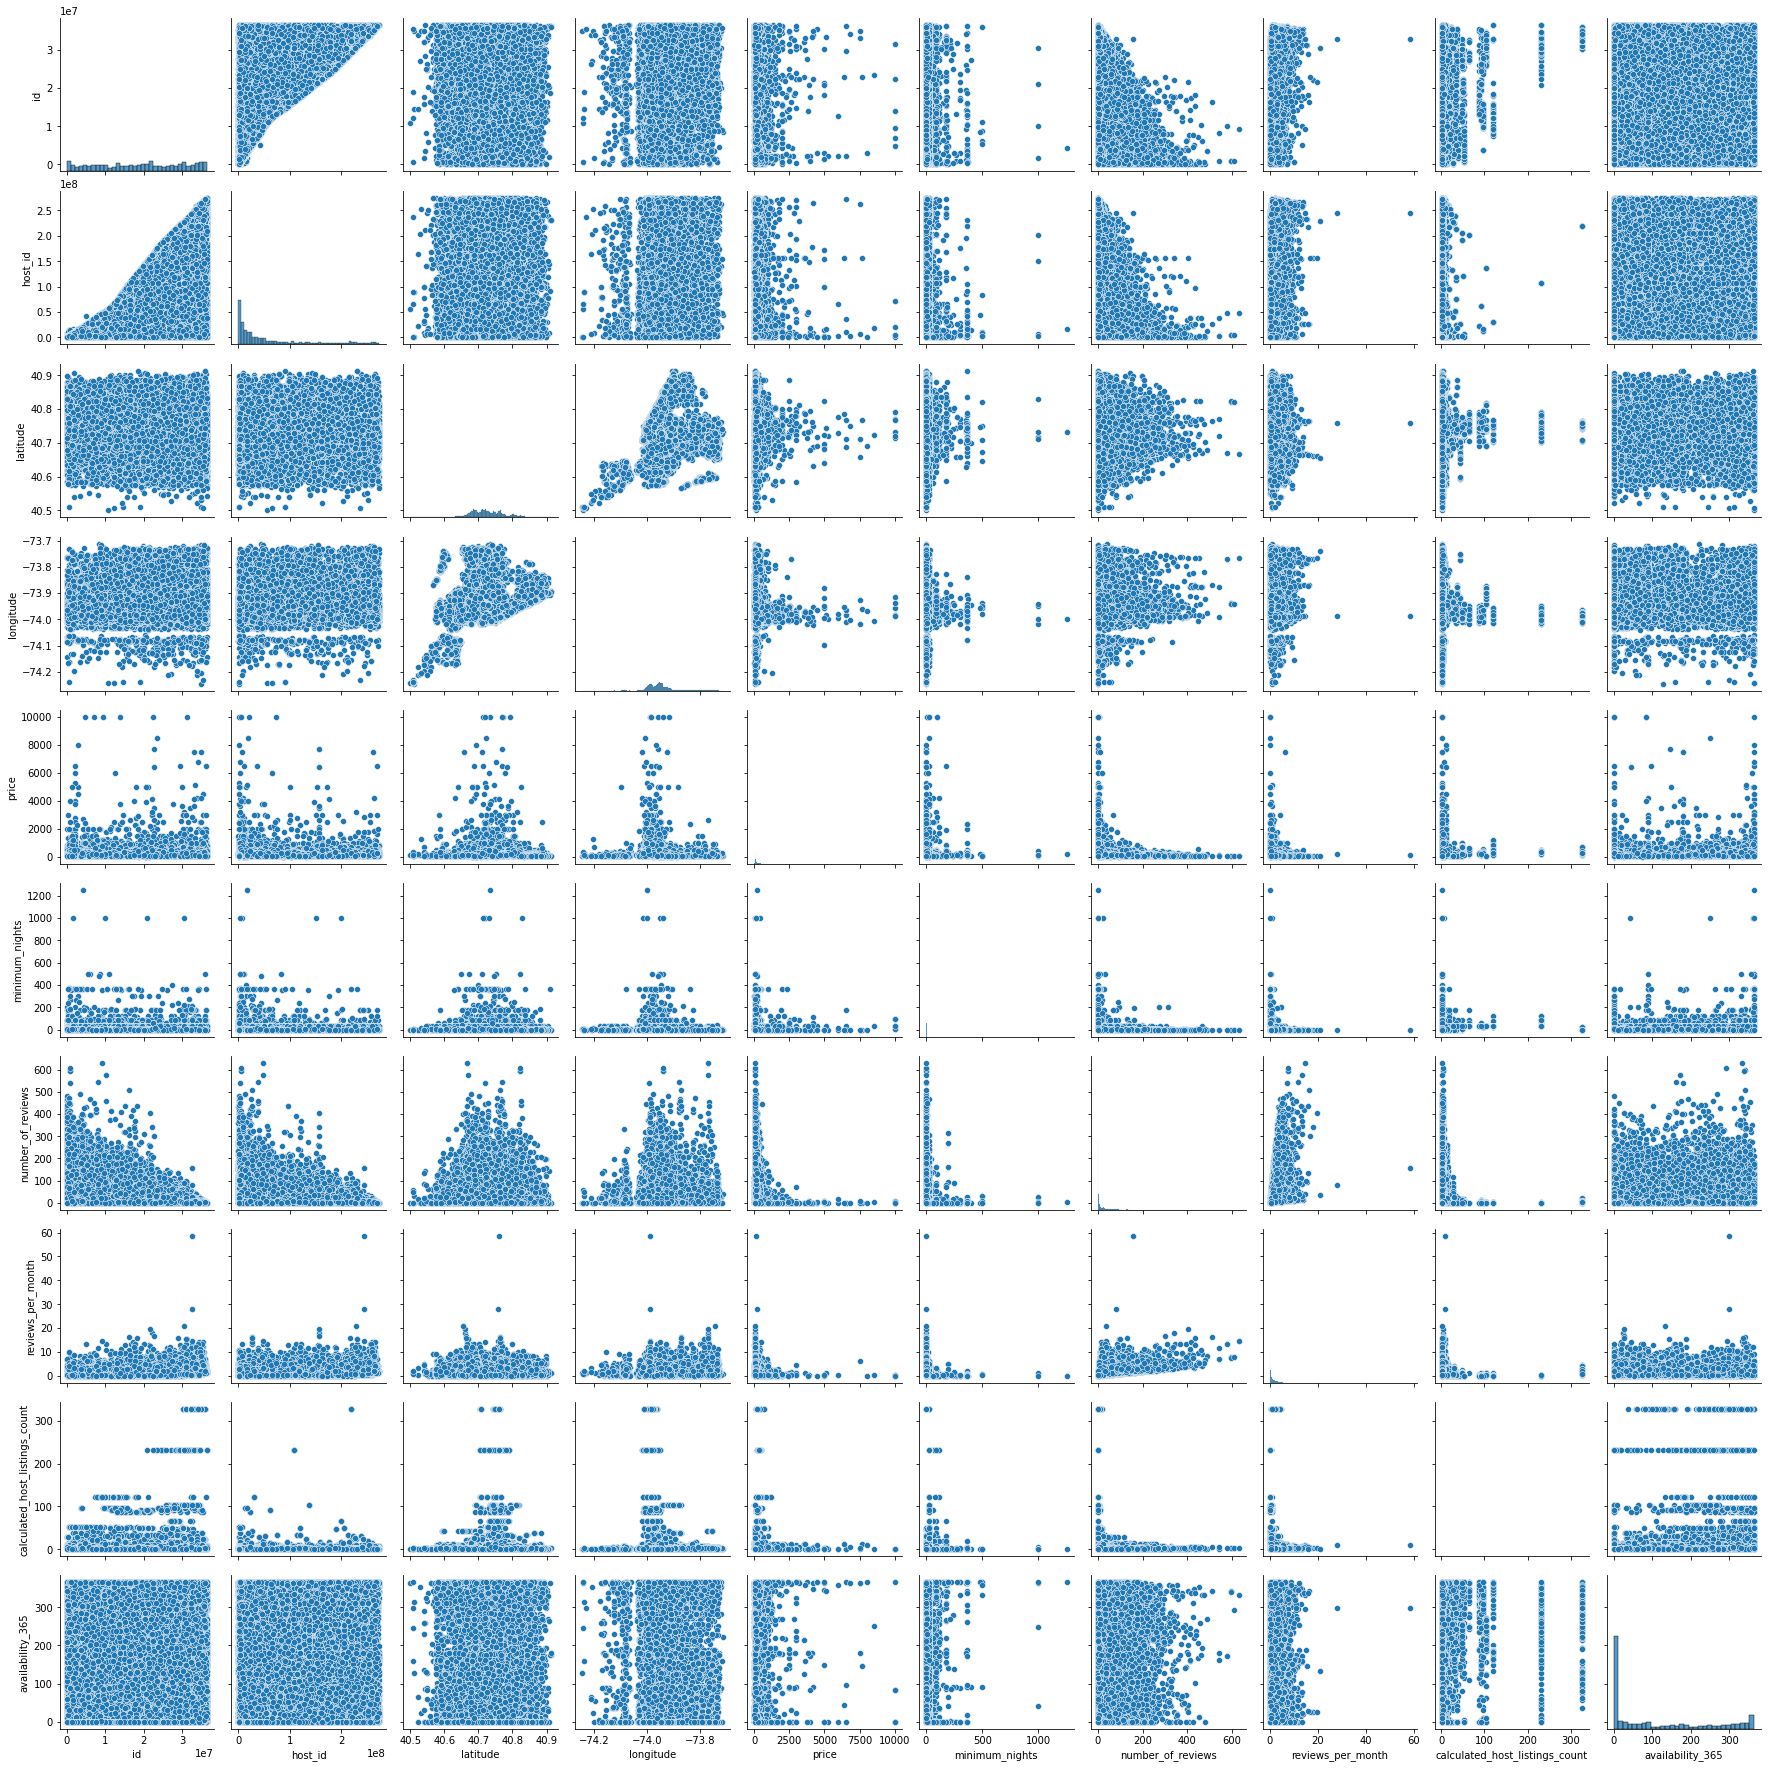

In [13]:
sns.pairplot(data);

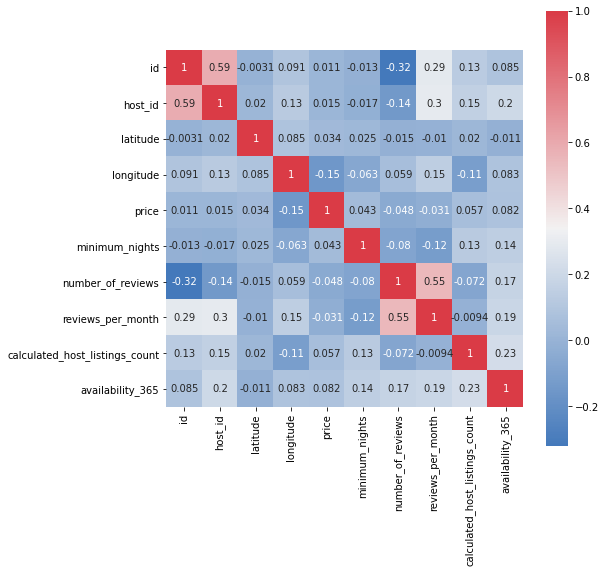

In [14]:
corr = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(8, 8))
sns.heatmap(corr, square=True, cmap=cmap, annot=True);

### Train Test Split

In [12]:
targets = data['price']

train_size = int(0.7*len(data))
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]

X_train

array([[2.00e+00, 5.00e+00, 1.30e-01, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [2.00e+00, 9.30e+01, 4.15e+00, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [2.90e+01, 2.00e+00, 7.10e-01, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       ...,
       [2.00e+00, 5.50e+01, 7.80e-01, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [2.00e+00, 8.20e+01, 3.70e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [5.00e+00, 2.00e+00, 4.00e-02, ..., 1.00e+00, 0.00e+00, 0.00e+00]])

### Linear Regression

In [30]:
class LinearModel:
    def __init__(self):
        # y_pred = W*X + b
        self.initializer = tf.keras.initializers.GlorotUniform()
    
    def loss(self, y, y_pred):
        # MAE
        return tf.reduce_mean(tf.abs(y - y_pred))
    
    def train(self, X, y, lr=0.00001, epochs=20, verbose=True):
            
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape((-1, 1)) # [1,2,3,4] -> [[1],[2],[3],[4]]
        
        self.W = tf.Variable(
            initial_value=self.initializer(shape=(len(X[0]), 1), dtype='float32'))
        self.b = tf.Variable(
            initial_value=self.initializer(shape=(1,), dtype='float32'))

        def train_step():
            with tf.GradientTape() as t:
                current_loss = self.loss(y, self.predict(X))

            dW, db = t.gradient(current_loss, [self.W, self.b])
            self.W.assign_sub(lr * dW) # W -= lr * dW
            self.b.assign_sub(lr * db)
            
            return current_loss
        
        for epoch in range(epochs):
            current_loss = train_step()
            if verbose:
                print(f'Epoch {epoch}: Loss: {current_loss.numpy()}') 
                
    def predict(self, X):
        return tf.matmul(X, self.W) + self.b

In [31]:
model = LinearModel()
model.train(X_train, y_train, epochs=200)

Epoch 0: Loss: 130.18460083007812
Epoch 1: Loss: 130.18125915527344
Epoch 2: Loss: 130.17791748046875
Epoch 3: Loss: 130.174560546875
Epoch 4: Loss: 130.17124938964844
Epoch 5: Loss: 130.16787719726562
Epoch 6: Loss: 130.16455078125
Epoch 7: Loss: 130.16122436523438
Epoch 8: Loss: 130.15792846679688
Epoch 9: Loss: 130.15457153320312
Epoch 10: Loss: 130.15126037597656
Epoch 11: Loss: 130.14796447753906
Epoch 12: Loss: 130.14463806152344
Epoch 13: Loss: 130.1413116455078
Epoch 14: Loss: 130.13800048828125
Epoch 15: Loss: 130.1346893310547
Epoch 16: Loss: 130.13136291503906
Epoch 17: Loss: 130.12806701660156
Epoch 18: Loss: 130.12477111816406
Epoch 19: Loss: 130.1214599609375
Epoch 20: Loss: 130.1181640625
Epoch 21: Loss: 130.11488342285156
Epoch 22: Loss: 130.11158752441406
Epoch 23: Loss: 130.1082763671875
Epoch 24: Loss: 130.10499572753906
Epoch 25: Loss: 130.10169982910156
Epoch 26: Loss: 130.0984344482422
Epoch 27: Loss: 130.09515380859375
Epoch 28: Loss: 130.0918731689453
Epoch 29: 

### Multi Layer Perceptron (MLP)

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [20]:
def R_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1.0 - residual / total
    return r2

adam_optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MAE
model.compile(
    optimizer=adam_optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.MAE,
        tf.keras.metrics.MSE,
        R_squared, # -1 and 1, < 0 => useless, 0 and 1 => better close to 1
    ]
)

In [22]:
print(len(X_train[0]))
model.fit(X_train, y_train, epochs=10)
model.save('mlp.h5') 

13
Epoch 1/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.6299 - mean_absolute_error: 64.6299 - mean_squared_error: 57823.5234 - R_squared: 0.2662
Epoch 2/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.6578 - mean_absolute_error: 64.6578 - mean_squared_error: 57818.0117 - R_squared: 0.2586
Epoch 3/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.5217 - mean_absolute_error: 64.5217 - mean_squared_error: 57738.7812 - R_squared: 0.2614
Epoch 4/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.5402 - mean_absolute_error: 64.5402 - mean_squared_error: 57696.6562 - R_squared: 0.2632
Epoch 5/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.4468 - mean_absolute_error: 64.4468 - mean_squared_error: 57708.2422 - R_squared: 0.2675
Epoch 6/10
1070/1070 [==============================] - 1s 1ms/step - loss: 64.4351 - mean_absolute_error: 64.4351 - mean_squared_error: 57688.6641 - R_squar

In [27]:
loaded_model = tf.keras.models.load_model('mlp.h5', custom_objects={"R_squared": R_squared})
print(loaded_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
loaded_model.predict(X_test)

array([[ 47.24137],
       [ 81.36581],
       [223.75339],
       ...,
       [ 53.30268],
       [186.66286],
       [ 62.41297]], dtype=float32)

In [26]:
print(loaded_model(X_test[:2]))
print(y_test[:2])

tf.Tensor(
[[47.24137]
 [81.36581]], shape=(2, 1), dtype=float32)
[120 120]
